# Końcówka K+R vs K — analiza danych (UCI)

In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as path_effects
from IPython.display import display, HTML


sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (7, 5)

##  Wczytanie danych z UCI

In [180]:
from pathlib import Path

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/krkopt/krkopt.data"
local_path = Path("krkopt.data")

cols = [
    "white_king_file",
    "white_king_rank",
    "white_rook_file",
    "white_rook_rank",
    "black_king_file",
    "black_king_rank",
    "white_depth_of_win",
]

df = pd.read_csv(local_path, header=None, names=cols)

print("Shape:", df.shape)
print("Unique depth values (raw):", df["white_depth_of_win"].unique())
df.head()

Shape: (28056, 7)
Unique depth values (raw): ['draw' 'zero' 'one' 'two' 'three' 'four' 'five' 'six' 'seven' 'eight'
 'nine' 'ten' 'eleven' 'twelve' 'thirteen' 'fourteen' 'fifteen' 'sixteen']


,white_king_file,white_king_rank,white_rook_file,white_rook_rank,black_king_file,black_king_rank,white_depth_of_win
0,a,1,b,3,c,2,draw
1,a,1,c,1,c,2,draw
2,a,1,c,1,d,1,draw
3,a,1,c,1,d,2,draw
4,a,1,c,2,c,1,draw


## Mapowanie plików szachowych (a–h) na liczby i porządkowanie danych

Mapujemy litery kolumn na liczby 1–8, ustandaryzowujemy typy i sprawdzamy braki.

In [181]:
file_map = {c: i for i, c in enumerate(list("abcdefgh"), start=1)}
depth_map = {
    "draw": -1, "zero": 0, "one": 1, "two": 2, "three": 3, "four": 4,
    "five": 5, "six": 6, "seven": 7, "eight": 8, "nine": 9,
    "ten": 10, "eleven": 11, "twelve": 12, "thirteen": 13,
    "fourteen": 14, "fifteen": 15, "sixteen": 16
}

# Mapowanie liter na liczby (tylko jesli kolumny są typu object/string)
cols_file = ["white_king_file", "white_rook_file", "black_king_file"]
for col in cols_file:
    if df[col].dtype == "object":
        df[col] = df[col].map(file_map)

# Mapowanie 'draw', 'zero', 'one' ... na liczby
if df["white_depth_of_win"].dtype == "object":
    df["white_depth_of_win"] = df["white_depth_of_win"].map(depth_map)

# Konwersja na numeric wszystkich kolumn
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")

print(df.dtypes)

df.head()

white_king_file       int64
white_king_rank       int64
white_rook_file       int64
white_rook_rank       int64
black_king_file       int64
black_king_rank       int64
white_depth_of_win    int64
dtype: object


,white_king_file,white_king_rank,white_rook_file,white_rook_rank,black_king_file,black_king_rank,white_depth_of_win
0,1,1,2,3,3,2,-1
1,1,1,3,1,3,2,-1
2,1,1,3,1,4,1,-1
3,1,1,3,1,4,2,-1
4,1,1,3,2,3,1,-1


## Pytanie 1: Pozycje czarnego króla dla mata i remisu

Heatmapy pokazują, gdzie najczęściej stoi czarny król przy macie (white-depth-of-win = 0) oraz przy remisie (white-depth-of-win = -1). Dane UCI są zredukowane względem symetrii, więc na potrzeby wizualizacji rozszerzamy pozycje przez odbicia planszy(w przypadku pozycji matowych).

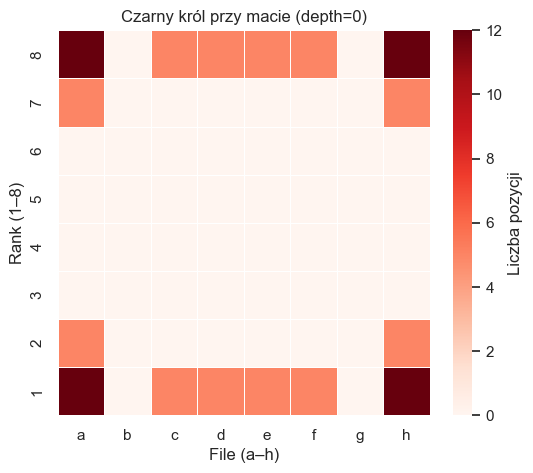

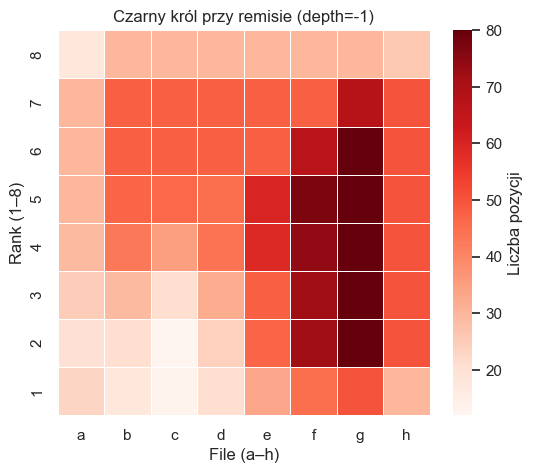

In [182]:
df_full = df.copy()

def heatmap_black_king(data, title, expand_symmetry=False):
    data_plot = data[["black_king_rank", "black_king_file"]].copy()

    if expand_symmetry:
        # Rozszerzenie przez symetrie (odbicia względem osi)
        r = data_plot["black_king_rank"]
        f = data_plot["black_king_file"]
        variants = [
            pd.DataFrame({"black_king_rank": r, "black_king_file": f}),
            pd.DataFrame({"black_king_rank": r, "black_king_file": 9 - f}),
            pd.DataFrame({"black_king_rank": 9 - r, "black_king_file": f}),
            pd.DataFrame({"black_king_rank": 9 - r, "black_king_file": 9 - f}),
        ]
        data_plot = pd.concat(variants, ignore_index=True)

    pivot = (
        data_plot.groupby(["black_king_rank", "black_king_file"]).size()
        .reset_index(name="count")
        .pivot(index="black_king_rank", columns="black_king_file", values="count")
        .reindex(index=range(1, 9), columns=range(1, 9))
        .fillna(0)
    )

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        pivot,
        cmap="Reds",
        linewidths=0.5,
        linecolor="white",
        xticklabels=list("abcdefgh"),
        yticklabels=list(range(1, 9)),
        cbar_kws={"label": "Liczba pozycji"},
    )
    plt.title(title)
    plt.xlabel("File (a–h)")
    plt.ylabel("Rank (1–8)")
    plt.gca().invert_yaxis()
    plt.show()

mate = df_full[df_full["white_depth_of_win"] == 0]
draw = df_full[df_full["white_depth_of_win"] == -1]

heatmap_black_king(mate, "Czarny król przy macie (depth=0)", expand_symmetry=True)
heatmap_black_king(draw, "Czarny król przy remisie (depth=-1)")

**Komentarz (P1):** Pierwszy wykres pokazuje że ta baza jednak nie jest pełna, bo inaczej by przy symmetrycznych pozycjach była by ta sama ilość ruchów co analogicznie w innym rogu. Natomiast widzimy pozycje matowe tylko w lewym górnym rogu. Następny wykres pokazuje że najwięcej remisów jest w odległości 1 od krawędzi co może być sensowne ze względu na możliwość stawiania w rogu(blokując najbliższą krawędz) natomiast król białych blokuje czarnego + zwykłych remisów kiedy biały gracz traci wieżę.

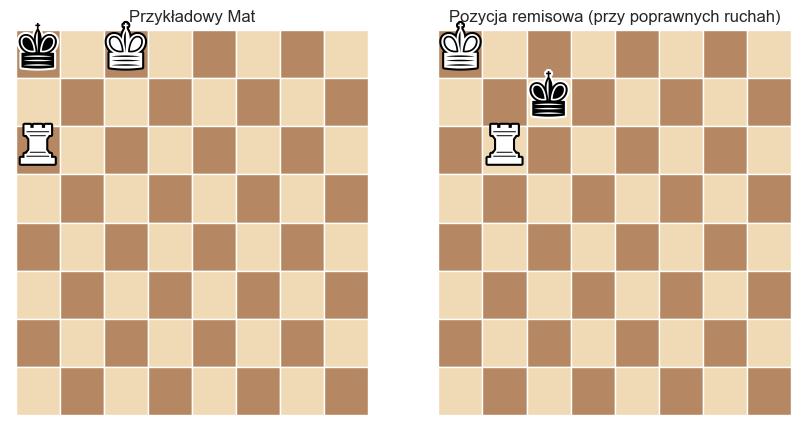

In [194]:

def plot_board(ax, pos, title):
    colors = ["#f0d9b5", "#b58863"]
    
    for r in range(1, 9):
        for f in range(1, 9):
            color = colors[(r + f) % 2 == 0]
            ax.add_patch(plt.Rectangle((f - 1, 8 - r), 1, 1, facecolor=color))

    pieces = [
        ("WK", "♚", "white", "black", pos["white_king_file"], pos["white_king_rank"]),
        ("WR", "♜", "white", "black", pos["white_rook_file"], pos["white_rook_rank"]),
        ("BK", "♚", "black", "white", pos["black_king_file"], pos["black_king_rank"]),
    ]

    for _, char, color, stroke, f, r in pieces:
        txt = ax.text(f - 0.5, 8 - r + 0.5, char, ha="center", va="center", 
                      fontsize=40, color=color, family="Segoe UI Symbol")
        txt.set_path_effects([path_effects.withStroke(linewidth=3, foreground=stroke)])

    ax.set_xlim(0, 8); ax.set_ylim(0, 8)
    ax.set_title(title)
    ax.axis("off") 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

plot_board(ax1, mate.iloc[0], "Przykładowy Mat")
plot_board(ax2, draw.iloc[0], "Pozycja remisowa (przy poprawnych ruchah)")

plt.show()

## Wyznaczenie dystansów król–król: Euklidesowy, Manhattan, Czebyszewa

Dodajemy kolumny z trzema metrykami odległości między białym i czarnym królem.

In [184]:
df_nodraw = df[df["white_depth_of_win"] != -1].copy()

In [185]:
dx = df_nodraw["white_king_file"] - df_nodraw["black_king_file"]
dy = df_nodraw["white_king_rank"] - df_nodraw["black_king_rank"]

# metryki
_df = df_nodraw.copy()
_df["d_E"] = np.sqrt(dx**2 + dy**2)
_df["d_M"] = np.abs(dx) + np.abs(dy)
_df["d_C"] = np.maximum(np.abs(dx), np.abs(dy))

_df[["d_E", "d_M", "d_C"]].describe().T

,count,mean,std,min,25%,50%,75%,max
d_E,25260.0,4.554889,1.722659,2.0,3.162278,4.472136,5.830952,9.899495
d_M,25260.0,5.787134,2.409603,2.0,4.000000,6.000000,7.000000,14.000000
d_C,25260.0,4.070784,1.525863,2.0,3.000000,4.000000,5.000000,7.000000


## Pytanie 2: Porównanie metryk dystansu vs. liczba ruchów do mata

Dla danych bez remisów sprawdzamy zależność liczby ruchów od metryk dystansu. Użyjemy wykresów trendu i korelacji rang Spearmana.

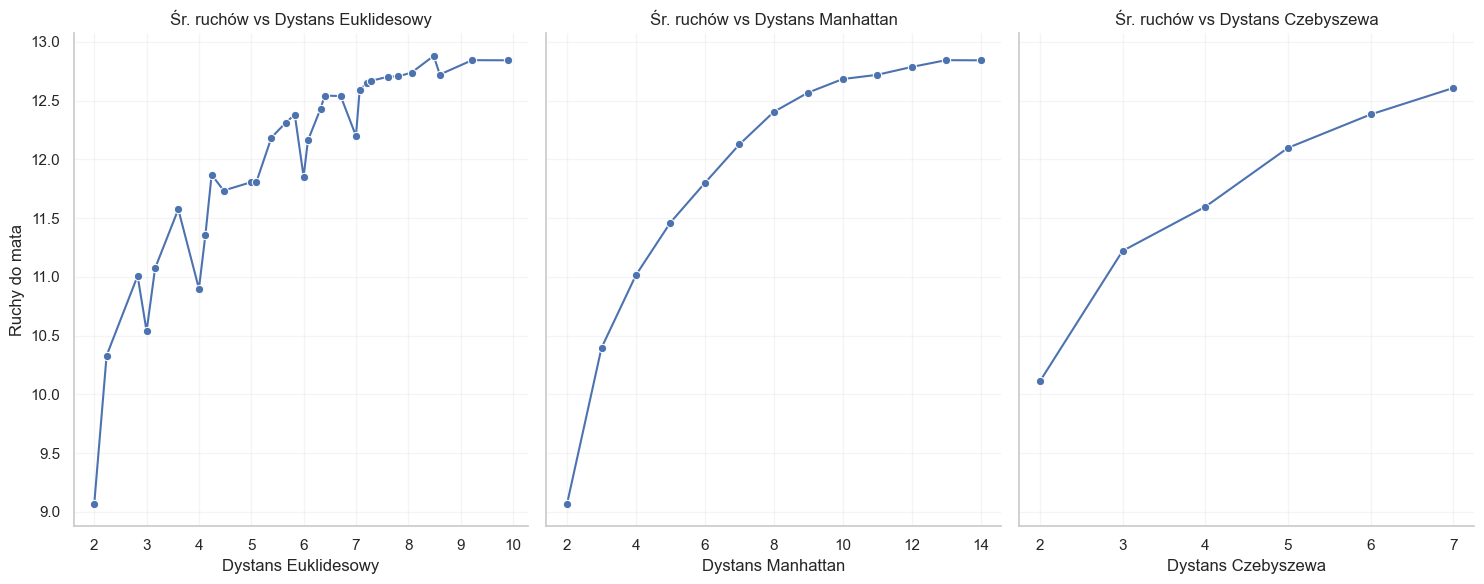

,metric,spearman
1,Dystans Manhattan,0.256605
0,Dystans Euklidesowy,0.242819
2,Dystans Czebyszewa,0.212660


In [192]:

metrics = ["d_E", "d_M", "d_C"]
metric_labels = {
    "d_E": "Dystans Euklidesowy",
    "d_M": "Dystans Manhattan",
    "d_C": "Dystans Czebyszewa",
}

# Korelacje Spearmana
corrs = {m: _df[[m, "white_depth_of_win"]].corr(method="spearman").iloc[0, 1] for m in metrics}
cor_df = pd.DataFrame({"metric": corrs.keys(), "spearman": corrs.values()}).sort_values("spearman", ascending=False)


# Trendy średniej liczby ruchów w zależności od metryki
fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)
for ax, m in zip(axes, metrics):
    tmp = _df.groupby(m)["white_depth_of_win"].mean().reset_index()
    sns.lineplot(data=tmp, x=m, y="white_depth_of_win", ax=ax, marker="o", color="#4C72B0")
    ax.set_title(f"Śr. ruchów vs {metric_labels[m]}")
    ax.set_xlabel(metric_labels[m])
    ax.set_ylabel("Ruchy do mata")
    ax.grid(alpha=0.2)

sns.despine()
plt.tight_layout()
plt.show()

cor_df["metric"] = cor_df["metric"].map(metric_labels)
display(cor_df)

**Komentarz (P2):** Najlepszą metryką ze względu na monotoniczność, gładkość wykresu oraz uwzględniając korelację rangową Spearmana jest metryka Manhatan. Ale dystans Czebyszewa też jest dobrym wyborem(mimo to że ma mnieszy wsp. korelacji niż 2 inne metryki).

**Uwaga:** dla metryki Czebyszewa wartości są całkowite i mają mało możliwych poziomów, więc po zgrupowaniu po 'd_C' na wykresie widać dużo mniej punktów niż dla dystansu Euklidesowego.

##  Wyznaczenie odległości czarnego króla od krawędzi planszy

`edge_dist` to minimalna odległość czarnego króla do **dowolnej** krawędzi planszy: minimum z (lewo, prawo, dół, góra).

In [187]:
bk_file = _df["black_king_file"]
bk_rank = _df["black_king_rank"]

_df["edge_dist"] = np.minimum.reduce([
    bk_file - 1,
    8 - bk_file,
    bk_rank - 1,
    8 - bk_rank
])

_df[["edge_dist"]].describe().T

,count,mean,std,min,25%,50%,75%,max
edge_dist,25260.0,0.833452,0.924874,0.0,0.0,1.0,1.0,3.0


## Pytanie 3: Związek odległości od krawędzi i dystansu król–król z liczbą ruchów

Analizujemy dwie **różne** cechy:
- `edge_dist`: bliskość czarnego króla do krawędzi planszy,
- najlepsza metryka dystansu król–król (np. Manhattan).

Wykres 2D pokazuje, jak te dwie informacje razem wpływają na liczbę ruchów do mata.

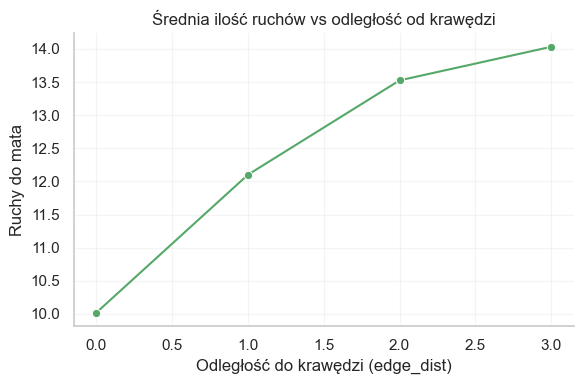

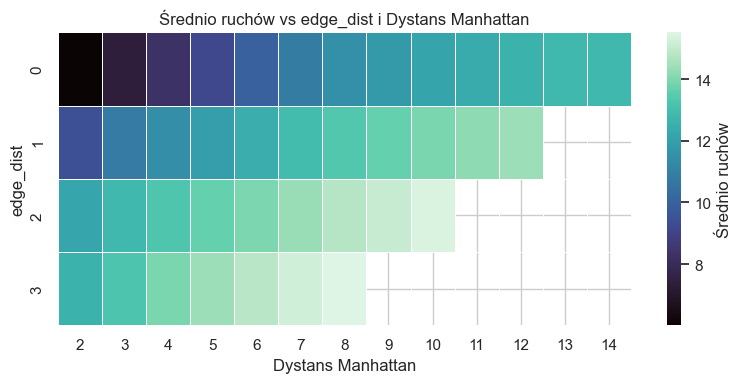

In [188]:
# 1D: średnia liczba ruchów vs odległość od krawędzi
edge_trend = _df.groupby("edge_dist")["white_depth_of_win"].mean().reset_index()

plt.figure(figsize=(6, 4))
sns.lineplot(data=edge_trend, x="edge_dist", y="white_depth_of_win", marker="o", color="#55A868")
plt.title("Średnia ilość ruchów vs odległość od krawędzi")
plt.xlabel("Odległość do krawędzi (edge_dist)")
plt.ylabel("Ruchy do mata")
plt.grid(alpha=0.2)
sns.despine()
plt.tight_layout()
plt.show()

# 2D: zależność od krawędzi i najlepszej metryki król–król
metric_label = metric_labels.get(best_metric, best_metric)

pivot = (
    _df.groupby(["edge_dist", best_metric])["white_depth_of_win"]
    .mean()
    .reset_index()
    .pivot(index="edge_dist", columns=best_metric, values="white_depth_of_win")
)

plt.figure(figsize=(8, 4))
sns.heatmap(pivot, cmap="mako", linewidths=0.5, linecolor="white", cbar_kws={"label": "Średnio ruchów"})
plt.title(f"Średnio ruchów vs edge_dist i {metric_label}")
plt.xlabel(metric_label)
plt.ylabel("edge_dist")
plt.tight_layout()
plt.show()

**Komentarz (P3):** Z pierwszego wykresu widoczna jest jawna korelecja: większy dystans do krawędzi - więcej ruchów do mata. Co zgadza się z rzeczywistością, bo mat wieżą + królem zawsze sprowadza się do tego że król przeciwnika musi być przy krawędzi. Drugi wykres pokazuje że oba wskazniki(dystans do innego króla + dystans do krawędzi) pomagają w przewidywaniu ilości kroków do końca. To znaczy że zmniejszenie dowolnego z nich, zmniejsza równierz oczekiwaną ilość ruchów do końca.